# Pytorch Tutorial 8

## RNN 01 - ready
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

    Min Max Normalization
    Parameters ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]

    Returns ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]

    References ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [1]:
# train Parameters
learning_rate = 0.01
num_epochs = 500
input_size = 5
hidden_size = 5
num_classes = 1
timesteps = seq_length = 7
num_layers = 1  # number of layers in RNN

In [2]:
# import modules
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import os
torch.manual_seed(777)  # reproducibility

In [3]:
if "DISPLAY" not in os.environ:
    matplotlib.use('Agg') # remove Travis CI Error

In [4]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [5]:
# RNN 분석 모델링 함수
# 익일 분석 모델링
def stock_predict_rnn(file):
    %matplotlib inline
    import pandas as pd; from time import time; t0 = time()
    xy = np.loadtxt(file, delimiter=',') # Open, High, Low, Volume, Close
    xy = xy[::-1] ; xy = MinMaxScaler(xy); x = xy
    y = xy[:, [-1]]  # Close as label

    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
        if i % 150 == 0:
            print(_x[0], "->", _y)

    # 모델링 결과 데이터 overview
    #plt.plot(xy)   plt.show()

    # train/test split
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    trainX = torch.Tensor(np.array(dataX[0:train_size]))
    trainX = Variable(trainX)
    testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
    testX = Variable(testX)
    trainY = torch.Tensor(np.array(dataY[0:train_size]))
    trainY = Variable(trainY)
    testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
    testY = Variable(testY)

    class LSTM(nn.Module):
        def __init__(self, num_classes, input_size, hidden_size, num_layers):
            super(LSTM, self).__init__()
            self.num_classes = num_classes
            self.num_layers = num_layers
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.seq_length = seq_length
            # Set parameters for RNN block
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)
            # Fully connected layer
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            # Initialize hidden and cell states
            h_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))
            # Propagate input through LSTM
            _, (h_out, _) = self.lstm(x, (h_0, c_0))
            h_out = h_out.view(-1, self.hidden_size)
            out = self.fc(h_out)
            return out

    # Instantiate RNN model
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    # Set loss and optimizer function
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]))
    print("Learning finished!")
    print(int(time()-t0)//60, 'min', int(time()-t0)%60, 'sec')

    # Test the model
    lstm.eval()
    test_predict = lstm(testX)

    # Plot predictions
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    test_predict = test_predict.data.numpy()
    testY = testY.data.numpy()
    plt.plot(testY)
    plt.plot(test_predict,'r')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

    # Plot predictions
    # GE는 가격의 지속적 상승이 예측
    plt.plot(testY[-15:])
    plt.plot(test_predict[-15:],'r')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [6]:
# RNN 예측 모델링 함수
# 5일 (1주) 예측 모델링
def stock_predict_rnn_5days(file):
    %matplotlib inline
    import pandas as pd; from time import time; t0 = time()
    xy = np.loadtxt(file, delimiter=',') # Open, High, Low, Volume, Close
    xy = xy[::-1] ; xy = MinMaxScaler(xy); x = xy
    y = xy[:, [-1]]  # Close as label

    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - 5):
        _x = x[i: i + seq_length]
        _y = y[i + seq_length + 5]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
        if i % 150 ==0:
            print(_x[0], "->", _y)

    # train/test split
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    trainX = torch.Tensor(np.array(dataX[0:train_size]))
    trainX = Variable(trainX)
    testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
    testX = Variable(testX)
    trainY = torch.Tensor(np.array(dataY[0:train_size]))
    trainY = Variable(trainY)
    testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
    testY = Variable(testY)

    class LSTM(nn.Module):
        def __init__(self, num_classes, input_size, hidden_size, num_layers):
            super(LSTM, self).__init__()
            self.num_classes = num_classes
            self.num_layers = num_layers
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.seq_length = seq_length
            # Set parameters for RNN block
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)
            # Fully connected layer
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            # Initialize hidden and cell states
            h_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))
            c_0 = Variable(torch.zeros(
                self.num_layers, x.size(0), self.hidden_size))
            # Propagate input through LSTM
            _, (h_out, _) = self.lstm(x, (h_0, c_0))
            h_out = h_out.view(-1, self.hidden_size)
            out = self.fc(h_out)
            return out

    # Instantiate RNN model
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    # Set loss and optimizer function
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]))
    print("Learning finished!")
    print(int(time()-t0)//60, 'min', int(time()-t0)%60, 'sec')

    # Test the model
    lstm.eval()
    test_predict = lstm(testX)

    # Plot predictions
    %matplotlib inline
    import matplotlib
    import matplotlib.pyplot as plt
    test_predict = test_predict.data.numpy()
    testY = testY.data.numpy()
    plt.plot(testY)
    plt.plot(test_predict,'r')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

    # Plot predictions
    # GE는 가격의 지속적 상승이 예측
    plt.plot(testY[-15:])
    plt.plot(test_predict[-15:],'r')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

## RNN Analysis 1 -  GE
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

[ 0.25098814  0.2513369   0.44053852  0.18547142  0.27329192] -> [ 0.42236024]
[ 0.86660078  0.89090908  0.90276738  0.07303483  0.85196686] -> [ 0.82608695]
[ 0.6916996   0.70053475  0.78309648  0.08161178  0.70600413] -> [ 0.78985506]
[ 0.4604743   0.44064171  0.5946148   0.12570505  0.4658385 ] -> [ 0.1884058]
[ 0.27470355  0.23208556  0.4644727   0.03640973  0.26397515] -> [ 0.19668737]
[ 0.27075099  0.228877    0.45100972  0.0303406   0.24534161] -> [ 0.35093167]
Epoch: 0, loss: 0.33560
Epoch: 100, loss: 0.00577
Epoch: 200, loss: 0.00563
Epoch: 300, loss: 0.00552
Epoch: 400, loss: 0.00542
Learning finished!
0 min 7 sec


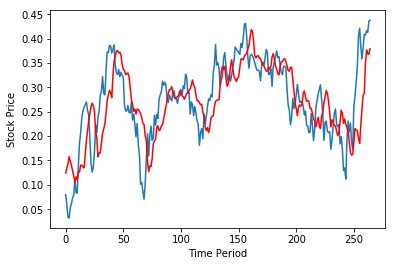

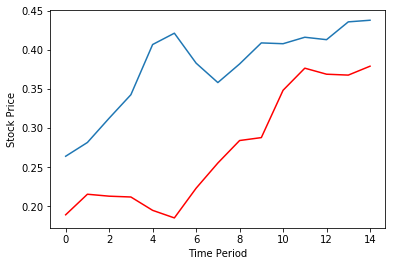

In [7]:
# 익일 주가 예측
#stock_predict_rnn('./Lecture/ge.csv')
# 5일 주가 예측
stock_predict_rnn_5days('./Lecture/ge.csv')

## RNN Analysis 2 -  LG디스플레이
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

[ 0.74082073  0.67959183  0.75687568  0.32234392  0.75990939] -> [ 0.93997734]
[ 0.49460043  0.46020408  0.50935093  0.12155646  0.48471121] -> [ 0.39297848]
[ 0.262419    0.22653061  0.25632563  0.20418041  0.22876557] -> [ 0.29558324]
[ 0.16846652  0.13877551  0.18041804  0.13459536  0.14835787] -> [ 0.18912797]
[ 0.67926565  0.63163265  0.69526952  0.2326139   0.69535673] -> [ 0.81426953]
[ 0.80129589  0.73673469  0.83058305  0.02007648  0.82219705] -> [ 0.83918459]
Epoch: 0, loss: 0.07496
Epoch: 100, loss: 0.00475
Epoch: 200, loss: 0.00450
Epoch: 300, loss: 0.00437
Epoch: 400, loss: 0.00430
Learning finished!
0 min 7 sec


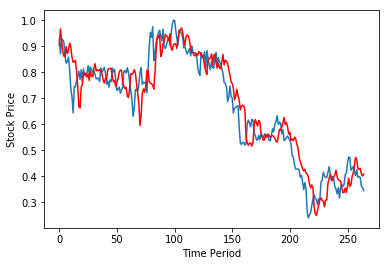

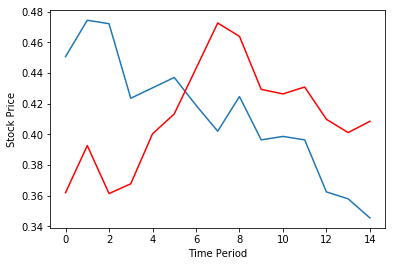

In [10]:
# 익일 주가 예측
#stock_predict_rnn('./Lecture/lgdisplay.csv')
# 5일 주가 예측
stock_predict_rnn_5days('./Lecture/lgdisplay.csv')

## RNN Analysis 3 -  GooGle
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

[ 0.99527665  0.99463807  0.99866221  0.0923509   0.99598125] -> [ 0.87876758]
[ 0.44871795  0.46514745  0.46822742  0.14074495  0.45880777] -> [ 0.39048895]
[ 0.13765182  0.14477212  0.15317726  0.18833864  0.1493637 ] -> [ 0.15539183]
[ 0.05060729  0.05093834  0.06488294  0.16132584  0.0522438 ] -> [ 0.04152713]
[ 0.19703104  0.19235925  0.20869565  0.05822129  0.19691896] -> [ 0.20830543]
[ 0.15047233  0.15214477  0.17190635  0.09416668  0.15070328] -> [ 0.17146685]
Epoch: 0, loss: 0.46578
Epoch: 100, loss: 0.00121
Epoch: 200, loss: 0.00113
Epoch: 300, loss: 0.00111
Epoch: 400, loss: 0.00110
Learning finished!
0 min 6 sec


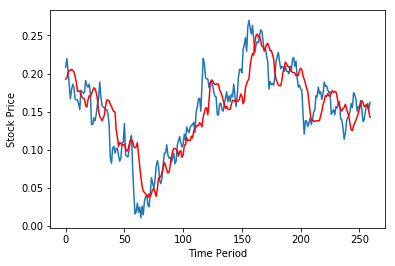

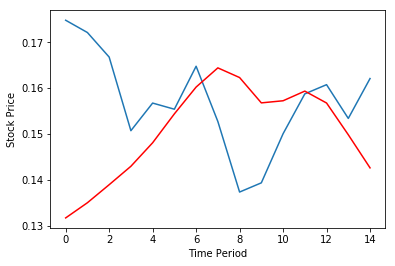

In [8]:
# 익일 주가 예측
#stock_predict_rnn('./Lecture/google.csv')
# 5일 주가 예측
stock_predict_rnn_5days('./Lecture/google.csv')

## RNN Analysis 4 - 삼성전자
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

[ 0.99527665  0.99463807  0.99866221  0.0923509   0.99598125] -> [ 0.87876758]
[ 0.44871795  0.46514745  0.46822742  0.14074495  0.45880777] -> [ 0.39048895]
[ 0.13765182  0.14477212  0.15317726  0.18833864  0.1493637 ] -> [ 0.15539183]
[ 0.05060729  0.05093834  0.06488294  0.16132584  0.0522438 ] -> [ 0.04152713]
[ 0.19703104  0.19235925  0.20869565  0.05822129  0.19691896] -> [ 0.20830543]
[ 0.15047233  0.15214477  0.17190635  0.09416668  0.15070328] -> [ 0.17146685]
Epoch: 0, loss: 0.42731
Epoch: 100, loss: 0.00116
Epoch: 200, loss: 0.00109
Epoch: 300, loss: 0.00108
Epoch: 400, loss: 0.00107
Learning finished!
0 min 6 sec


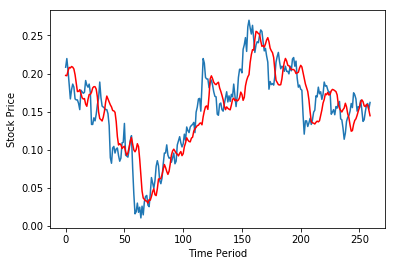

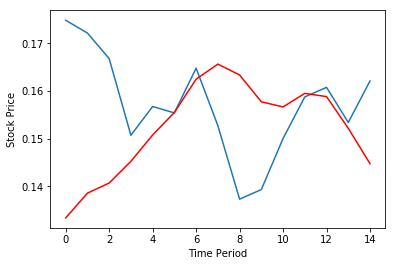

In [9]:
# 익일 주가 예측
#stock_predict_rnn('./Lecture/samsung.csv')
# 5일 주가 예측
stock_predict_rnn_5days('./Lecture/samsung.csv')